In [84]:
import warnings
import hazm
import re
import time
import ast
import random
import pandas as pd

from hazm import stopwords_list
from hazm import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from cleantext import clean

from tqdm import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from wordcloud_fa import WordCloudFa

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
tqdm.pandas()

# Data Reading

In [3]:
base_path = "../data/"

input_file = base_path + "remote_tweets.csv"
emojies_file = base_path + "emojies.txt"

In [4]:
contextual_cols = ['tweet', 'hashtags']
tweets_df = pd.read_csv(input_file, low_memory=False, usecols=contextual_cols)
tweets_df.head()

,tweet,hashtags
0,به من گزارش میده حقوقش میدونم سالی ۸۵تا، همسرش...,NaN
1,اینایی که رفتن سفر، مهمونی و... هیچ پروتکلی هم...,NaN
2,دارم فکر میکنم که چقدر خسته ام با اینکه امروز ...,NaN
3,یک سال و نیمه از قبل آبان ۹۸ دورکار شدم تا الان,NaN
4,@shahrzaad حتمن میرفتم به شهری که به اقوام یا ...,NaN


# Data Pre-processing

## Duplicate chars/emojies

In [5]:
emojies_content = open(base_path + 'emojies.txt',  encoding="utf8")
emojies = list(line.strip() for line in emojies_content)
emojies_str = ' '.join(e for e in emojies)
duplicate_emojies_pattern = "(?P<char>[" + re.escape(emojies_str) + "])(?P=char)*"

In [6]:
def remove_duplicates(text) : 
    dups = re.finditer(r"(.)\1{2,}", text)
    dup_list = []
    for d in dups:
        dup_list.append(d.group())
    
    for d in dup_list:
        text = text.replace(d, d[0]) #reduce chars with 3 or more repeats in a row to 1
    
    text = re.sub(duplicate_emojies_pattern, r" \1 ", text) #reduce emoji repeats to 1 and separate it from other tokens
    return text

## Text cleaning

- Unicode errors
- URLs
- Phone numbers
- emails
- currency symbols
- useless punctuations and chars

In [7]:
punctuations_file = open(base_path + 'stop-words/punctuations.txt',  encoding="utf8")
punctuations = list(line.strip() for line in punctuations_file)

imp_punctuations_file = open(base_path + 'imp_punctuations.txt',  encoding="utf8")
imp_punctuation_str = ' '.join(e for e in imp_punctuations_file)
imp_punctuation_pattern = "(?P<char>[" + re.escape(imp_punctuation_str) + "])(?P=char)*"

conversational_to_normal = {
   'کورونا': "کرونا",
    'خونه': "خانه",
    'تموم': "تمام",
    'کرونای': "کرونا",
    'امریکا': "آمریکا",
    'انلاین': "آنلاین",
}

space_list = ['_', '\s+']

useless_chars = re.compile("["
        # u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        # u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        # u"\U0001f926-\U0001f937"
        # u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


In [8]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def clean_text(text, is_hashtag=False) :
    text = str(text).strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )
    
    # HTML
    text = clean_html(text)
    
    # useless patterns
    text = useless_chars.sub(r'', text)
    
    # urls with http/https
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", '', text)
    
    # unncessary characters and punctuations
    if is_hashtag == False: # to keep underlines in hashtags
        for r in space_list:
            text = text.replace(r, ' ')
        
    for p in punctuations:
        text = text.replace(p, ' ')
    
    text = re.sub(imp_punctuation_pattern, r" \1 ", text)
    
    
    # conversational to normal form
    for key, value in conversational_to_normal.items():
        text.replace(key, value)
        
    text = re.sub(' +', ' ', text)
    return text

## Normalization

In [9]:
normalizer = hazm.Normalizer()

def get_normalization(text):
    return normalizer.normalize(text)

## Stop-words

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/taha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words_fa = set(stopwords_list()) 
stop_words_en = set(stopwords.words('english'))

bullshitsFile = open(base_path + 'stop-words/bullshits.txt',  encoding="utf8")
charsFile = open(base_path + 'stop-words/chars.txt',  encoding="utf8")
infinitivesFile = open(base_path + 'stop-words/infinitives.txt',  encoding="utf8")
nonverbalFile = open(base_path + 'stop-words/nonverbal.txt',  encoding="utf8")
persianFile = open(base_path + 'stop-words/persian.txt',  encoding="utf8")
shortFile = open(base_path + 'stop-words/short.txt',  encoding="utf8")
verbalFile = open(base_path + 'stop-words/verbal.txt',  encoding="utf8")

bullshits = set(line.strip() for line in bullshitsFile)
chars = set(line.strip() for line in charsFile)
infinitives = set(line.strip() for line in infinitivesFile)
nonverbal = set(line.strip() for line in nonverbalFile)
persian = set(line.strip() for line in persianFile)
short = set(line.strip() for line in shortFile)
verbal = set(line.strip() for line in verbalFile)

stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)
stop_words = stop_words.union(bullshits)
stop_words = stop_words.union(chars)
stop_words = stop_words.union(infinitives)
stop_words = stop_words.union(nonverbal)
stop_words = stop_words.union(persian)
stop_words = stop_words.union(short)
stop_words = stop_words.union(verbal)

In [12]:
def remove_stopwords(text) :
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    text = " ".join([word for word in tokens_without_sw])
    return text

## Lemmatization

In [13]:
lemmatizer = hazm.Lemmatizer()

def lemmatize_tweet(text) : 
    return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

## Cleaning Procedure

In [14]:
def clean_data(data_df, col_name) :
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_duplicates(t))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: clean_text(t, col_name == 'hashtags'))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df[col_name + '_tokens'] = data_df[col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df['lemmatized_' + col_name] = data_df[col_name].progress_apply(lambda t: lemmatize_tweet(t)) 
    data_df['lemmatized_' + col_name] = data_df['lemmatized_' + col_name].progress_apply(lambda t: remove_stopwords(t))
    data_df['lemmatized_' + col_name + '_token'] = data_df['lemmatized_' + col_name].progress_apply(lambda t: word_tokenize(t))
    
    data_df[col_name + '_size'] = data_df[col_name + '_tokens'].progress_apply(lambda t: len(t))
    data_df['lemmatized_' + col_name + '_size'] = data_df['lemmatized_' + col_name + '_token'].progress_apply(lambda t: len(t))

In [15]:
clean_data(tweets_df, 'tweet')
tweets_df.head()

100%|████████████████████████████████| 45359/45359 [00:00<00:00, 1058352.44it/s]


,tweet,hashtags,tweet_tokens,lemmatized_tweet,lemmatized_tweet_token,tweet_size,lemmatized_tweet_size
0,گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا ...,NaN,"[گزارش, حقوقش, میدونم, سالی, ۸۵, همسرش, دانشجو...",گزارش حقوق میدونم ۸۵ همسر دانشجو دکترا شرکت اح...,"[گزارش, حقوق, میدونم, ۸۵, همسر, دانشجو, دکترا,...",32,30
1,اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خط...,NaN,"[اینایی, سفر, مهمونی, پروتکلی, رعایت, نکردن, س...",اینایی سفر مهمونی پروتکل رعایت نکردن سرکار خطر...,"[اینایی, سفر, مهمونی, پروتکل, رعایت, نکردن, سر...",11,11
2,خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده ...,NaN,"[خسته, دورکاری, شهرهای, سروصدا, شب, ازصبح, آزا...",خسته دورکاری شهر سروصدا شب ازصبح آزاردهنده تره...,"[خسته, دورکاری, شهر, سروصدا, شب, ازصبح, آزارده...",26,26
3,آبان ۹۸ دورکار,NaN,"[آبان, ۹۸, دورکار]",آبان ۹۸ دورکار,"[آبان, ۹۸, دورکار]",3,3
4,حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجا...,NaN,"[حتمن, میرفتم, شهری, اقوام, دوستام, نزدیکتر, خ...",حتمن میرفتم شهر اقوام دوستام خونه اجازه میکردم...,"[حتمن, میرفتم, شهر, اقوام, دوستام, خونه, اجازه...",16,15
...,...,...,...,...,...,...,...
95,دورکاری خوبه هنوزم کار,NaN,"[دورکاری, خوبه, هنوزم, کار]",دورکاری خوبه کار,"[دورکاری, خوبه, کار]",4,3
96,دورکاری,NaN,[دورکاری],دورکاری,[دورکاری],1,1
97,رییس جمهور شم سربازی حذف نهار شام پخت غذا کار ...,NaN,"[رییس, جمهور, شم, سربازی, حذف, نهار, شام, پخت,...",رییس جمهور شم سرباز حذف نهار شام پخت#پز غذا کا...,"[رییس, جمهور, شم, سرباز, حذف, نهار, شام, پخت#پ...",19,16
98,دوست اسلک دورکارمون کنن ممکنه دورکار بکنن,NaN,"[دوست, اسلک, دورکارمون, کنن, ممکنه, دورکار, بکنن]",دوست اسلک دورکارمون کنن ممکنه دورکار بکنن,"[دوست, اسلک, دورکارمون, کنن, ممکنه, دورکار, بکنن]",7,7


# Hashtags

In [19]:
def get_list_from_str(text):
    if type(text) == str:
        return ast.literal_eval(text)
    else:
        return []

In [20]:
tweets_df['hashtags'] = tweets_df['hashtags'].progress_apply(lambda h: get_list_from_str(h))

100%|█████████████████████████████████| 45359/45359 [00:00<00:00, 306827.20it/s]


In [23]:
tweets_df.head()

,tweet,hashtags,tweet_tokens,lemmatized_tweet,lemmatized_tweet_token,tweet_size,lemmatized_tweet_size
0,گزارش حقوقش میدونم سالی ۸۵ همسرش دانشجو دکترا ...,[],"[گزارش, حقوقش, میدونم, سالی, ۸۵, همسرش, دانشجو...",گزارش حقوق میدونم ۸۵ همسر دانشجو دکترا شرکت اح...,"[گزارش, حقوق, میدونم, ۸۵, همسر, دانشجو, دکترا,...",32,30
1,اینایی سفر مهمونی پروتکلی رعایت نکردن سرکار خط...,[],"[اینایی, سفر, مهمونی, پروتکلی, رعایت, نکردن, س...",اینایی سفر مهمونی پروتکل رعایت نکردن سرکار خطر...,"[اینایی, سفر, مهمونی, پروتکل, رعایت, نکردن, سر...",11,11
2,خسته دورکاری شهرهای سروصدا شب ازصبح آزاردهنده ...,[],"[خسته, دورکاری, شهرهای, سروصدا, شب, ازصبح, آزا...",خسته دورکاری شهر سروصدا شب ازصبح آزاردهنده تره...,"[خسته, دورکاری, شهر, سروصدا, شب, ازصبح, آزارده...",26,26
3,آبان ۹۸ دورکار,[],"[آبان, ۹۸, دورکار]",آبان ۹۸ دورکار,"[آبان, ۹۸, دورکار]",3,3
4,حتمن میرفتم شهری اقوام دوستام نزدیکتر خونه اجا...,[],"[حتمن, میرفتم, شهری, اقوام, دوستام, نزدیکتر, خ...",حتمن میرفتم شهر اقوام دوستام خونه اجازه میکردم...,"[حتمن, میرفتم, شهر, اقوام, دوستام, خونه, اجازه...",16,15


In [78]:
def get_listof_all_tokens(data_df, col_name):
    all_tokens = []
    for index, row in tqdm(data_df.iterrows()):
        all_tokens.extend(row[col_name])
        
    random.shuffle(all_tokens)
    
    return all_tokens

hashtag_words = get_listof_all_tokens(tweets_df, 'hashtags')

45359it [00:01, 28424.02it/s]


(-0.5, 999.5, 799.5, -0.5)

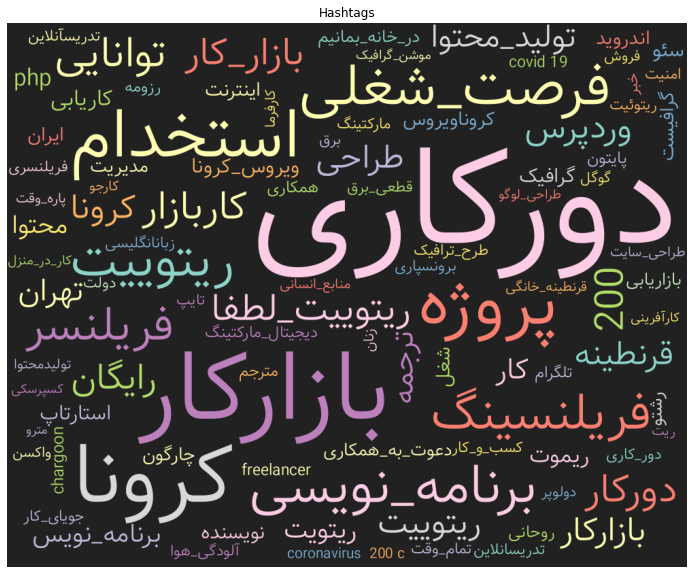

In [80]:
plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=200,
                 width=1000, 
                 height=800)
wc.generate(" ".join(hashtag_words))
plt.gca().imshow(wc)
plt.gca().set_title('Hashtags', fontdict=dict(size=12))
plt.gca().axis('off')

# Tweets

In [85]:
def get_uni_bi_tri_grams(text):
    tokens = word_tokenize(text)
    
    bigrams = list(ngrams(tokens, 2)) if len(tokens) >= 2 else []
    bigram_tokens = [' '.join(b) for b in bigrams]
    
    trigrams = list(ngrams(tokens, 3)) if len(tokens) >= 3 else []
    trigram_tokens = [' '.join(t) for t in trigrams]
    
    tokens = tokens + bigram_tokens + trigram_tokens
    return tokens

In [93]:
def get_listof_all_tweet_tokens(data_df, col_name):
    col_n_grams = data_df[col_name].progress_apply(lambda t: get_uni_bi_tri_grams(t))
    all_tokens = []
    for index, value in tqdm(col_n_grams.items()):
        all_tokens.extend(value)
    
    random.shuffle(all_tokens)
    
    return all_tokens

## Lemmatized

100%|██████████████████████████████████| 45359/45359 [00:01<00:00, 41480.02it/s]
45359it [00:00, 1036973.80it/s]


(-0.5, 999.5, 799.5, -0.5)

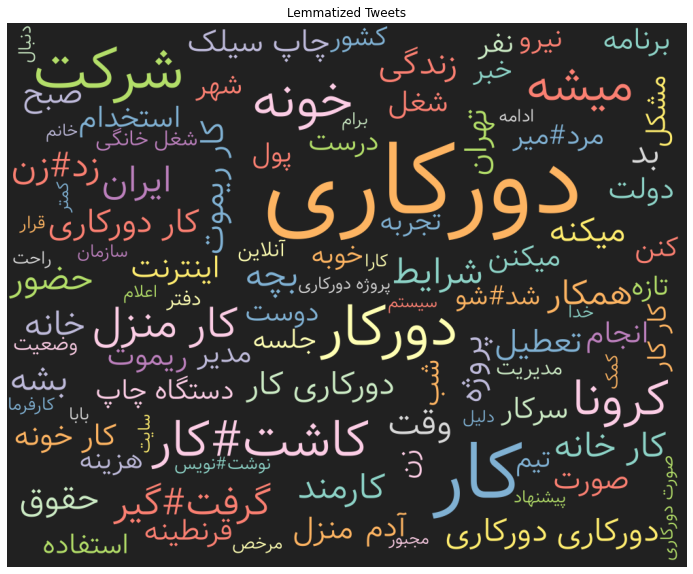

In [96]:
lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'lemmatized_tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')

## Non-Lemmatized

100%|██████████████████████████████████| 45359/45359 [00:01<00:00, 40655.20it/s]
45359it [00:00, 916330.41it/s]


(-0.5, 999.5, 799.5, -0.5)

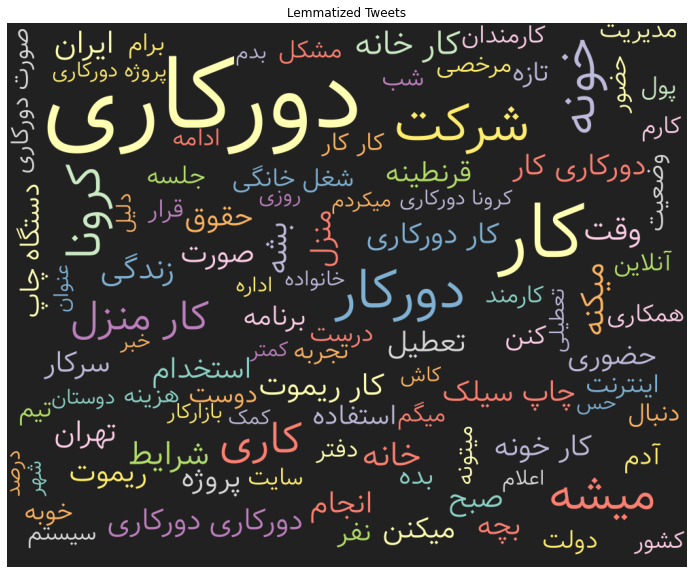

In [98]:
non_lemmatized_tweets_words = get_listof_all_tweet_tokens(tweets_df, 'tweet')

plt.figure(figsize=(20,10))

wc = WordCloudFa(background_color="#212121",
                 no_reshape = True,
                 max_words=100,
                 colormap='Set3', 
                 max_font_size=150,
                 width=1000, 
                 height=800)
wc.generate(" ".join(non_lemmatized_tweets_words))
plt.gca().imshow(wc)
plt.gca().set_title('Lemmatized Tweets', fontdict=dict(size=12))
plt.gca().axis('off')